# Applying Seq2Seq Model with Attention in Sorting Problems

---


In [1]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.python.layers import core as layers_core

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class Dummy(object):
    pass

## Default Values

In [3]:
batch_size = 128
input_size = 30
max_time = 20
embedding_size = 10
num_units = embedding_size

## Generate Data

In [4]:
def next_batch(batch_size, seq_len, max_time, input_size=10):
    data = np.zeros((batch_size, max_time), dtype='int32')
    data[:,:seq_len] = np.random.randint(1, input_size+1, (batch_size, seq_len))
    labels = np.zeros((batch_size, max_time), dtype='int32')
    labels[:,:seq_len] = np.sort(data[:, :seq_len])
    
    # time major
    return data.T, labels.T

## The Seq2Seq Model

In [5]:
def initialization():
    model = Dummy()
    model.encoder_inputs = tf.placeholder('int32', [max_time, None], name='encoder_inputs')
    model.targets = tf.placeholder('int32', [max_time, None], name='target')
    model.decoder_inputs = tf.concat([tf.fill([1, tf.shape(model.targets)[1]], 0), model.targets[:-1,:]], 0)
    
    model.source_sequence_lengths = tf.placeholder('int32', [None], name='source_sequence_lengths')
    model.target_sequence_lengths = tf.placeholder('int32', [None], name='target_sequence_lengths')
    
    model.learning_rate = tf.placeholder('float32', [], name='learning_rate')
    model.max_gradient_norm = tf.placeholder('float32', [], name='max_gradient_norm') # often set to a value like 5 or 1

    
    return model

In [6]:
def embedding(model):
    with tf.variable_scope("embedding", dtype='float32') as scope:
        # Embedding
        embedding_encoder = tf.get_variable("embedding_encoder", [input_size+1, embedding_size])
        embedding_decoder = tf.get_variable("embedding_decoder", [input_size+1, embedding_size])
        
        # Look up embedding:
        #   encoder_inputs: [max_time, batch_size]
        #   encoder_emp_inp: [max_time, batch_size, embedding_size]
        encoder_emb_inp = tf.nn.embedding_lookup(embedding_encoder, model.encoder_inputs)
        decoder_emb_inp = tf.nn.embedding_lookup(embedding_decoder, model.decoder_inputs)
        
        model.embedding_encoder = embedding_encoder
        model.embedding_decoder = embedding_decoder
        model.encoder_emb_inp = encoder_emb_inp
        model.decoder_emb_inp = decoder_emb_inp
        
    return model

In [7]:
# The Encoder
def encoder(model):
    with tf.variable_scope("encoder", dtype='float32') as scope:
        # Build RNN cell
        encoder_cell = tf.contrib.rnn.GRUCell(num_units)

        # Run Dynamic RNN
        #   encoder_outpus: [max_time, batch_size, num_units]
        #   encoder_state: [batch_size, num_units]
        encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
            encoder_cell, model.encoder_emb_inp, dtype='float32',
            sequence_length=model.source_sequence_lengths, time_major=True)
        
        model.encoder_outputs = encoder_outputs
        model.encoder_state = encoder_state
        
    return model

In [9]:
# ## Decoder
def decoder(model):
    with tf.variable_scope("decoder", dtype='float32') as scope:
        """ Attention Mechanisms """
        # attention_states: [batch_size, max_time, num_units]
        attention_states = tf.transpose(model.encoder_outputs, [1, 0, 2])

        # Create an attention mechanism
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(
            num_units, attention_states, scale=True,
            memory_sequence_length=model.source_sequence_lengths)

        
        decoder_cell = tf.contrib.rnn.GRUCell(num_units)

        decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
            decoder_cell, attention_mechanism,
            alignment_history=True,
            attention_layer_size=num_units, name="attention")

        decoder_initial_state = decoder_cell.zero_state(tf.shape(model.decoder_emb_inp)[1], 'float32').clone(cell_state=model.encoder_state)
        """"""
        # Helper
        helper = tf.contrib.seq2seq.TrainingHelper(
            model.decoder_emb_inp, model.target_sequence_lengths, time_major=True)
        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, decoder_initial_state)
        # Dynamic decoding
        outputs, final_context_state, _ = tf.contrib.seq2seq.dynamic_decode(
            decoder,
            output_time_major=True,
            swap_memory=True,
            scope=scope)

        #projection
        output_layer = layers_core.Dense(input_size+1, use_bias=False, name="output_projection")
        logits = output_layer(outputs.rnn_output)
        
    model.logits = logits
    model.decoder_cell = decoder_cell
    model.decoder_initial_state = decoder_initial_state
    model.output_layer = output_layer
    model.final_context_state = final_context_state
    
    return model

In [10]:
# ## Loss & Gradient computation & optimization

def optimizer(model):
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights) / tf.to_float(tf.shape(model.decoder_emb_inp)[1])

    # Calculate and clip gradients
    parameters = tf.trainable_variables()
    gradients = tf.gradients(loss, parameters)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, model.max_gradient_norm)

    # Optimization
    optimizer = tf.train.GradientDescentOptimizer(model.learning_rate)
    update_step = optimizer.apply_gradients(zip(clipped_gradients, parameters))
    
    model.loss = loss
    model.update_step = update_step
    
    return model

In [11]:
def create_model():
    model = initialization()
    model = embedding(model)
    model = encoder(model)
    model = decoder(model)
    model = optimizer(model)
    
    return model

In [12]:
model = create_model()

In [13]:
# ## Running training

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [57]:
for i in range(6000):
    
    if i==0:
        lr = 1.
    elif i==3000:
        lr = .5
    elif i==4000:
        lr = .25
    elif i==50000:
        lr = .125
    
    seq_len = 15
    x, y = next_batch(batch_size, seq_len, max_time, input_size)
    feed_dict={model.learning_rate: lr,
               model.max_gradient_norm: 1,
               model.source_sequence_lengths: [seq_len+1]*batch_size,
               model.target_sequence_lengths: [seq_len+1]*batch_size,
               model.encoder_inputs: x,
               model.targets: y}


    _, l_val = sess.run([model.update_step, model.loss], feed_dict=feed_dict)
    print(i, l_val, end='\r')

In [15]:
# # Evaluating the network
def evaluation(model):
    # In[34]:

    model.maximum_iterations = tf.round(tf.reduce_max(model.source_sequence_lengths) * 2)


    # In[35]:

    with tf.variable_scope('decoder', reuse=True) as scope:
    # Dynamic decoding
        # Helper
        helper_eval = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            model.embedding_decoder, tf.fill([tf.shape(model.decoder_emb_inp)[1]], 0),
            0)
        # Decoder
        decoder_eval = tf.contrib.seq2seq.BasicDecoder(
            model.decoder_cell, helper_eval, model.decoder_initial_state,
            output_layer=model.output_layer)

        outputs_eval, final_context_state_eval, _ = tf.contrib.seq2seq.dynamic_decode(
            decoder_eval, maximum_iterations=model.maximum_iterations,
            swap_memory=True, scope=scope)

        model.logits_eval = outputs_eval.rnn_output
        
    curr_max_time = tf.shape(model.logits)[0]
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=model.targets[:curr_max_time,:], logits=model.logits)
    target_weights = tf.sequence_mask(model.target_sequence_lengths, curr_max_time, dtype=model.logits.dtype)

    # When time_major is True
    target_weights = tf.transpose(target_weights)

    loss = tf.reduce_sum(crossent * target_weights) / tf.to_float(tf.shape(model.decoder_emb_inp)[1])
    
    model.loss_eval = loss
    model.final_context_state_eval = final_context_state_eval
    
    return model

In [16]:
model_eval = evaluation(model)

In [28]:
attention_images = (model.final_context_state_eval.alignment_history.stack())
# Reshape to (batch, src_seq_len, tgt_seq_len,1)
attention_images = tf.expand_dims(tf.transpose(attention_images, [1, 2, 0]), -1)

In [ ]:
def prettify_stn(stn):
    ret = []
    for w in stn:
        if w == 0:
            break
        else:
            ret.append(w)
    return ret

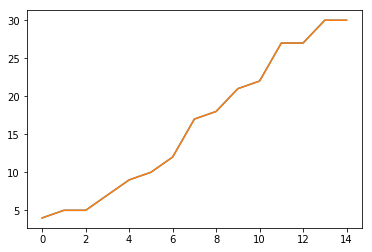

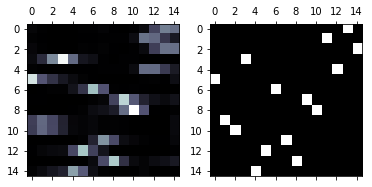

In [65]:
x, y = next_batch(batch_size, seq_len, max_time, input_size)
feed_dict={model.learning_rate: lr,
           model.max_gradient_norm: 1,
           model.source_sequence_lengths: [seq_len+1]*batch_size,
           model.target_sequence_lengths: [seq_len+1]*batch_size,
           model.encoder_inputs: x,
           model.targets: y}

d = prettify_stn(feed_dict[model.encoder_inputs][:,0])

plt.plot(np.argmax(sess.run(model.logits_eval, feed_dict),2)[0][:len(d)])
plt.plot(np.sort(d))

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(sess.run(attention_images, feed_dict)[0][:,:,0][:len(d),:len(d)], cmap='bone')
ax2.matshow(np.eye(len(d))[np.argsort(d)].T, cmap='bone')